# Kalman filtering and smoothing

In [89]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`


In the following set of examples the goal is to estimate hidden states of a Dynamical process where all hidden states are Gaussians.

We start our journey with a simple multivariate Linear Gaussian State Space Model (LGSSM), which can be solved analytically.

We then solve an identification problem which does not have an analytical solution.

Utimately, we show how **RxInfer.jl** can deal with missing observations.

## Gaussian Linear Dynamical System

LGSSM can be described with the following equations:

$$\begin{aligned}
 p(x_i|x_{i - 1}) & = \mathcal{N}(x_i|A * x_{i - 1}, \mathcal{P}),\\
 p(y_i|x_i) & = \mathcal{N}(y_i|B * x_i, \mathcal{Q}),
\end{aligned}$$

where $x_i$ are hidden states, $y_i$ are noisy observations, $A$, $B$ are state transition and observational matrices, $\mathcal{P}$ and $\mathcal{Q}$ are state transition noise and observation noise covariance matrices. For a more rigorous introduction to Linear Gaussian Dynamical systems we refer to [Simo Sarkka, Bayesian Filtering and Smoothing](https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf) book.

To model this process in `RxInfer`, first, we start with importing all needed packages:

In [90]:
using RxInfer, BenchmarkTools, Random, LinearAlgebra, Plots

Next step, is to generate some synthetic data:

In [91]:
function generate_data(rng, A, B, Q, P)
    x_prev = [ 10.0, -10.0 ]

    x = Vector{Vector{Float64}}(undef, n)
    y = Vector{Vector{Float64}}(undef, n)

    for i in 1:n
        x[i] = rand(rng, MvNormal(A * x_prev, Q))
        y[i] = rand(rng, MvNormal(B * x[i], P))
        x_prev = x[i]
    end
    
    return x, y
end

generate_data (generic function with 2 methods)

In [92]:
# Seed for reproducibility
seed = 1234

rng = MersenneTwister(1234)

# We will model 2-dimensional observations with rotation matrix `A`
# To avoid clutter we also assume that matrices `A`, `B`, `P` and `Q`
# are known and fixed for all time-steps
θ = π / 35
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
B = diageye(2)
Q = diageye(2)
P = 25.0 .* diageye(2)

# Number of observations
n = 300;

In [93]:
x, y = generate_data(rng, A, B, Q, P);

Let's plot our synthetic dataset. Lines represent our hidden states we want to estimate using noisy observations, which are represented as dots.

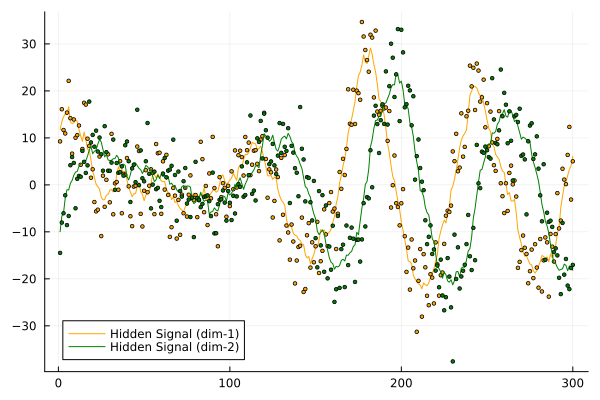

In [94]:
px = plot()

px = plot!(px, getindex.(x, 1), label = "Hidden Signal (dim-1)", color = :orange)
px = scatter!(px, getindex.(y, 1), label = false, markersize = 2, color = :orange)
px = plot!(px, getindex.(x, 2), label = "Hidden Signal (dim-2)", color = :green)
px = scatter!(px, getindex.(y, 2), label = false, markersize = 2, color = :green)

plot(px)

To create a model we use `GraphPPL` package and `@model` macro:

In [95]:
@model function rotate_ssm(y, x0, A, B, Q, P)
    x_prior ~ MvNormalMeanCovariance(mean(x0), cov(x0))
    x_prev = x_prior
    
    for i in 1:length(y)
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q)
        y[i] ~ MvNormalMeanCovariance(B * x[i], P)
        x_prev = x[i]
    end

end

To run inference we also specify prior for out first hidden state:

In [96]:
x0 = MvNormalMeanCovariance(zeros(2), 100.0 * diageye(2));

In [97]:
# For large number of observations you need to use limit_stack_depth = 100 option during model creation, e.g. 
# infer(..., options = (limit_stack_depth = 500, ))`
result = infer(
    model = rotate_ssm(x0=x0, A=A, B=B, Q=Q, P=P), 
    data = (y = y,),
    free_energy = true
);

xmarginals  = result.posteriors[:x]
logevidence = -result.free_energy; # given the analytical solution, free energy will be equal to the negative log evidence

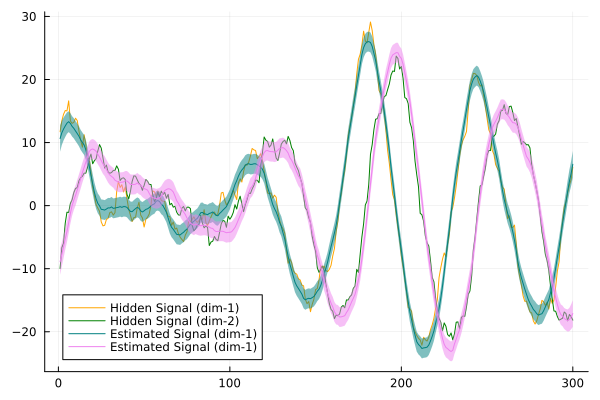

In [98]:
px = plot()

px = plot!(px, getindex.(x, 1), label = "Hidden Signal (dim-1)", color = :orange)
px = plot!(px, getindex.(x, 2), label = "Hidden Signal (dim-2)", color = :green)

px = plot!(px, getindex.(mean.(xmarginals), 1), ribbon = getindex.(var.(xmarginals), 1) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal (dim-1)", color = :teal)
px = plot!(px, getindex.(mean.(xmarginals), 2), ribbon = getindex.(var.(xmarginals), 2) .|> sqrt, fillalpha = 0.5, label = "Estimated Signal (dim-1)", color = :violet)

plot(px)

As we can see from our plot, estimated signal resembles closely to the real hidden states with small variance. We maybe also interested in the value for minus log evidence:

In [99]:
logevidence

1-element Vector{Float64}:
 -1882.2434870099432

## System Identification Problem

In this example we are going to attempt to run Bayesian inference and decouple two random-walk signals, which were combined into a single single through some deterministic function `f`. We do not have access to the real values of these signals, but only to their combination. First, we create the `generate_data` function that accepts `f` as an argument:

In [100]:
using RxInfer, Distributions, StableRNGs, Plots

In [101]:
function generate_data(f, n; seed = 123, x_i_min = -20.0, w_i_min = 20.0, noise = 20.0, real_x_τ = 0.1, real_w_τ = 1.0)

    rng = StableRNG(seed)

    real_x = Vector{Float64}(undef, n)
    real_w = Vector{Float64}(undef, n)
    real_y = Vector{Float64}(undef, n)

    for i in 1:n
        real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
        real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
        real_y[i] = rand(rng, Normal(f(real_x[i], real_w[i]), sqrt(noise)))

        x_i_min = real_x[i]
        w_i_min = real_w[i]
    end
    
    return real_x, real_w, real_y
end

generate_data (generic function with 2 methods)

The function returns the real signals `real_x` and  `real_w` for later comparison (we are not going to use them during inference) and their combined version `real_y` (we are going to use it as our observations during the inference). We also assume that `real_y` is corrupted with some measurement noise.

### Combination 1: y = x + w

In our first example, we are going to use a simple addition (`+`) as the function `f`. In general, it is impossible to decouple the signals `x` and `w` without strong priors, but we can try and see how good an inference can be. The `+` operation on two random variables also has a special meaning in the probabilistic inference, namely the convolution of pdf's of the two random variables, and `RxInfer` treats it specially with many precomputed analytical rules, which may make the inference task easier. First, let us create a test dataset:

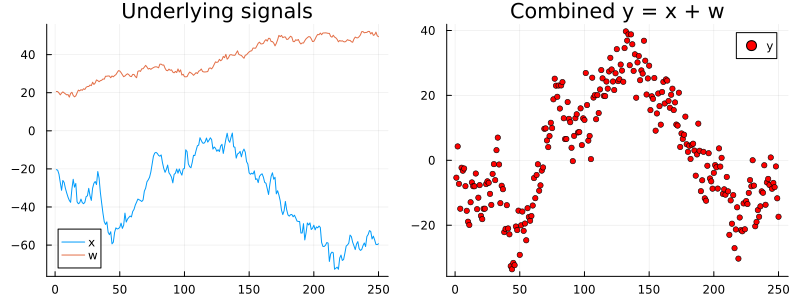

In [102]:
n = 250
real_x, real_w, real_y = generate_data(+, n);

pl = plot(title = "Underlying signals")
pl = plot!(pl, real_x, label = "x")
pl = plot!(pl, real_w, label = "w")

pr = plot(title = "Combined y = x + w")
pr = scatter!(pr, real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

To run inference, we need to create a probabilistic model: our beliefs about how our data could have been generated. For this we can use the `@model` macro from `RxInfer.jl`:

In [103]:
@model function identification_problem(f, y, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y)
    
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x_i_min = x0
    w_i_min = w0

    local x
    local w
    local s
    
    for i in 1:length(y)
        x[i] ~ Normal(mean = x_i_min, precision = τ_x)
        w[i] ~ Normal(mean = w_i_min, precision = τ_w)
        s[i] := f(x[i], w[i])
        y[i] ~ Normal(mean = s[i], precision = τ_y)
        
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
end

`RxInfer` runs Bayesian inference as a variational optimisation procedure between the real solution and its variational proxy `q`. In our model specification we assumed noise components to be unknown, thus, we need to enforce a structured mean-field assumption for the variational family of distributions `q`. This inevitably reduces the accuracy of the result, but makes the task easier and allows for fast and analytical message passing-based variational inference:

In [104]:
constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s) = q(x, x0, w, w0, s)q(τ_w)q(τ_x)q(τ_y)
end

Constraints: 
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s) = q(x, x0, w, w0, s)q(τ_w)q(τ_x)q(τ_y)


The next step is to assign priors, initialise needed messages and marginals and call the `inference` function:

In [105]:
m_x_0, τ_x_0 = -20.0, 1.0
m_w_0, τ_w_0 = 20.0, 1.0

# We set relatively strong priors for random walk noise components
# and sort of vague prior for the noise of the observations
a_x, b_x = 0.01, 0.01var(real_x)
a_w, b_w = 0.01, 0.01var(real_w)
a_y, b_y = 1.0, 1.0

# We set relatively strong priors for messages
xinit = map(r -> NormalMeanPrecision(r, τ_x_0), reverse(range(-60, -20, length = n)))
winit = map(r -> NormalMeanPrecision(r, τ_w_0), range(20, 60, length = n))


init = @initialization begin
    μ(x) = xinit
    μ(w) = winit
    q(τ_x) = GammaShapeRate(a_x, b_x)
    q(τ_w) = GammaShapeRate(a_w, b_w)
    q(τ_y) = GammaShapeRate(a_y, b_y)
end

result = infer(
    model = identification_problem(f=+, m_x_0=m_x_0, τ_x_0=τ_x_0, a_x=a_x, b_x=b_x, m_w_0=m_w_0, τ_w_0=τ_w_0, a_w=a_w, b_w=b_w, a_y=a_y, b_y=b_y),
    data  = (y = real_y,), 
    options = (limit_stack_depth = 500, ), 
    constraints = constraints, 
    initialization = init,
    iterations = 50
)

Inference results:
  Posteriors       | available for (x, w, x0, s, τ_x, τ_w, τ_y, w0)


Let's examine our inference results:

In [106]:
τ_x_marginals = result.posteriors[:τ_x]
τ_w_marginals = result.posteriors[:τ_w]
τ_y_marginals = result.posteriors[:τ_y]

smarginals = result.posteriors[:s]
xmarginals = result.posteriors[:x]
wmarginals = result.posteriors[:w];

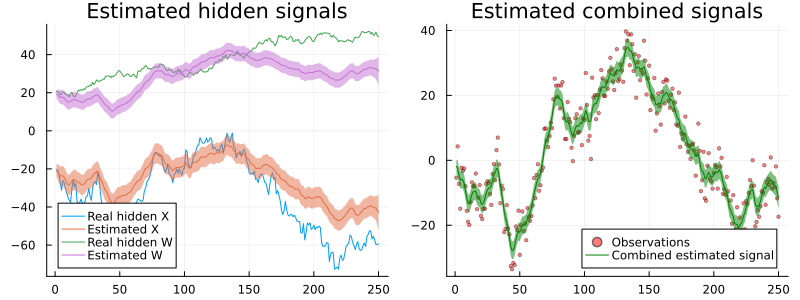

In [107]:
px1 = plot(legend = :bottomleft, title = "Estimated hidden signals")
px2 = plot(legend = :bottomright, title = "Estimated combined signals")

px1 = plot!(px1, real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(xmarginals[end]), ribbon = var.(xmarginals[end]), label = "Estimated X")

px1 = plot!(px1, real_w, label = "Real hidden W")
px1 = plot!(px1, mean.(wmarginals[end]), ribbon = var.(wmarginals[end]), label = "Estimated W")

px2 = scatter!(px2, real_y, label = "Observations", ms = 2, alpha = 0.5, color = :red)
px2 = plot!(px2, mean.(smarginals[end]), ribbon = std.(smarginals[end]), label = "Combined estimated signal", color = :green)

plot(px1, px2, size = (800, 300))

The inference results are not so bad, even though `RxInfer` missed the correct values of the signals between `100` and `150`.

### Combination 2: y = min(x, w)

In this example we use a slightly more complex function, for which `RxInfer` does not have precomputed analytical message update rules. We are going to attempt to run Bayesian inference with `min` as a combination function. Note, however, that directly using `min` may cause problems for the built-in approximation methods as it has zero partial derviates with respect to all but one of the variables. We generate data with the `min` function directly however we model it with a somewhat smoothed version:

In [108]:
# Smoothed version of `min` without zero-ed derivatives
function smooth_min(x, y)    
    if x < y
        return x + 1e-4 * y
    else
        return y + 1e-4 * x
    end
end

smooth_min (generic function with 1 method)

`RxInfer` supports arbitrary nonlinear functions, but it requires an explicit approximation method specification. That can be achieved with the built-in `@meta` macro:

In [109]:
min_meta = @meta begin 
    # In this example we are going to use a simple `Linearization` method
    smooth_min() -> Linearization()
end

GraphPPL.MetaSpecification(GraphPPL.MetaObject[smooth_min() -> Linearization()], Union{GraphPPL.GeneralSubModelMeta, GraphPPL.SpecificSubModelMeta}[])

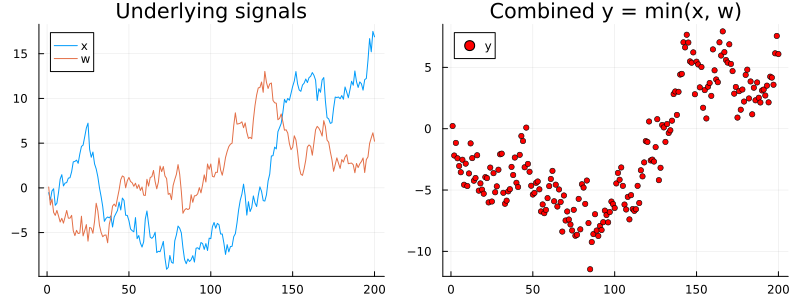

In [110]:
n = 200
min_real_x, min_real_w, min_real_y = generate_data(min, n, seed = 1, x_i_min = 0.0, w_i_min = 0.0, noise = 1.0, real_x_τ = 1.0, real_w_τ = 1.0);

pl = plot(title = "Underlying signals")
pl = plot!(pl, min_real_x, label = "x")
pl = plot!(pl, min_real_w, label = "w")

pr = plot(title = "Combined y = min(x, w)")
pr = scatter!(pr, min_real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

In [111]:
min_m_x_0, min_τ_x_0 = -1.0, 1.0
min_m_w_0, min_τ_w_0 = 1.0, 1.0

min_a_x, min_b_x = 1.0, 1.0
min_a_w, min_b_w = 1.0, 1.0
min_a_y, min_b_y = 1.0, 1.0

init = @initialization begin
   μ(x) = NormalMeanPrecision(min_m_x_0, min_τ_x_0) 
   μ(w) = NormalMeanPrecision(min_m_w_0, min_τ_w_0)
   q(τ_x) = GammaShapeRate(min_a_x, min_b_x) 
   q(τ_w) = GammaShapeRate(min_a_w, min_b_w)
   q(τ_y) = GammaShapeRate(min_a_y, min_b_y)
end


min_result = infer(
    model = identification_problem(f=smooth_min, m_x_0=min_m_x_0, τ_x_0=min_τ_x_0, a_x=min_a_x, b_x=min_b_x, m_w_0=min_m_w_0, τ_w_0=min_τ_w_0, a_w=min_a_w, b_w=min_b_w, a_y=min_a_y, b_y=min_b_y),
    data  = (y = min_real_y,), 
    options = (limit_stack_depth = 500, ), 
    constraints = constraints, 
    initialization = init,
    meta = min_meta,
    iterations = 50
)

Inference results:
  Posteriors       | available for (x, w, x0, s, τ_x, τ_w, τ_y, w0)


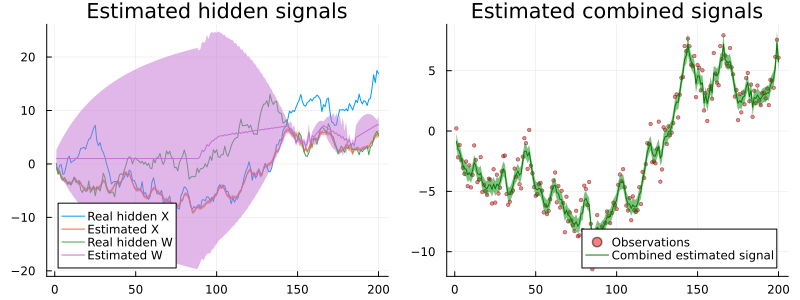

In [112]:
min_τ_x_marginals = min_result.posteriors[:τ_x]
min_τ_w_marginals = min_result.posteriors[:τ_w]
min_τ_y_marginals = min_result.posteriors[:τ_y]

min_smarginals = min_result.posteriors[:s]
min_xmarginals = min_result.posteriors[:x]
min_wmarginals = min_result.posteriors[:w]

px1 = plot(legend = :bottomleft, title = "Estimated hidden signals")
px2 = plot(legend = :bottomright, title = "Estimated combined signals")

px1 = plot!(px1, min_real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(min_xmarginals[end]), ribbon = var.(min_xmarginals[end]), label = "Estimated X")

px1 = plot!(px1, min_real_w, label = "Real hidden W")
px1 = plot!(px1, mean.(min_wmarginals[end]), ribbon = var.(min_wmarginals[end]), label = "Estimated W")

px2 = scatter!(px2, min_real_y, label = "Observations", ms = 2, alpha = 0.5, color = :red)
px2 = plot!(px2, mean.(min_smarginals[end]), ribbon = std.(min_smarginals[end]), label = "Combined estimated signal", color = :green)

plot(px1, px2, size = (800, 300))

As we can see inference with the `min` function is significantly harder. Even though the combined signal has been inferred with high precision the underlying `x` and `w` signals are barely inferred. This may be expected, since the `min` function essentially destroy the information about one of the signals, thus, making it impossible to decouple two seemingly identical random walk signals. The only one inferred signal is the one which is lower and we have no inference information about the signal which is above. It might be possible to infer the states, however, with more informative priors and structural information about two different signals (e.g. if these are not random walks). 

### Online (filtering) identification: y = min(x, w)

Another way to approach to this problem is to use online (filtering) inference procedure from `RxInfer`, but for that we also need to modify our model specification a bit:

In [113]:
@model function rx_identification(f, m_x_0, τ_x_0, m_w_0, τ_w_0, a_x, b_x, a_y, b_y, a_w, b_w, y)
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x ~ Normal(mean = x0, precision = τ_x)
    w ~ Normal(mean = w0, precision = τ_w)

    s := f(x, w)
    y ~ Normal(mean = s, precision = τ_y)
    
end

We impose structured mean-field assumption for this model as well:

In [114]:
rx_constraints = @constraints begin 
    q(x0, x, w0, w, τ_x, τ_w, τ_y, s) = q(x0, x)q(w, w0)q(τ_w)q(τ_x)q(s)q(τ_y)
end

Constraints: 
    q(x0, x, w0, w, τ_x, τ_w, τ_y, s) = q(x0, x)q(w, w0)q(τ_w)q(τ_x)q(s)q(τ_y)


Online inference in the `RxInfer` supports the `@autoupdates` specification, which tells inference procedure how to update priors based on new computed posteriors:

In [115]:
autoupdates = @autoupdates begin 
    m_x_0, τ_x_0 = mean_precision(q(x))
    m_w_0, τ_w_0 = mean_precision(q(w))
    a_x = shape(q(τ_x)) 
    b_x = rate(q(τ_x))
    a_y = shape(q(τ_y))
    b_y = rate(q(τ_y))
    a_w = shape(q(τ_w)) 
    b_w = rate(q(τ_w))
end

(m_x_0,τ_x_0 = mean_precision(q(x)), m_w_0,τ_w_0 = mean_precision(q(w)), a_x = shape(q(τ_x)), b_x = rate(q(τ_x)), a_y = shape(q(τ_y)), b_y = rate(q(τ_y)), a_w = shape(q(τ_w)), b_w = rate(q(τ_w)))

As previously we need to define the `@meta` structure that specifies the approximation method for the nonlinear function `smooth_min` (`f` in the model specification):

In [116]:
rx_meta = @meta begin 
    smooth_min() -> Linearization()
end

GraphPPL.MetaSpecification(GraphPPL.MetaObject[smooth_min() -> Linearization()], Union{GraphPPL.GeneralSubModelMeta, GraphPPL.SpecificSubModelMeta}[])

Next step is to generate our dataset and to run the actual inference procedure! For that we use the `infer` function with `autoupdates` keyword:

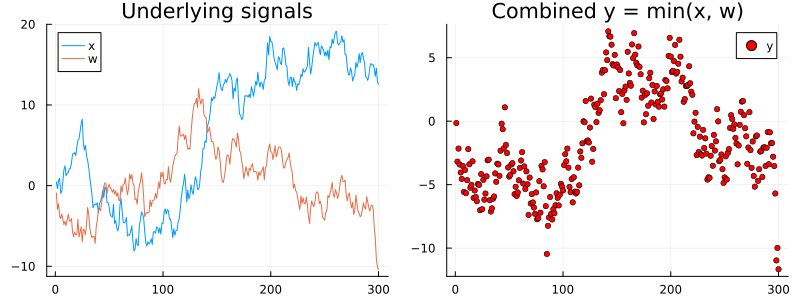

In [117]:
n = 300
rx_real_x, rx_real_w, rx_real_y = generate_data(min, n, seed = 1, x_i_min = 1.0, w_i_min = -1.0, noise = 1.0, real_x_τ = 1.0, real_w_τ = 1.0);

pl = plot(title = "Underlying signals")
pl = plot!(pl, rx_real_x, label = "x")
pl = plot!(pl, rx_real_w, label = "w")

pr = plot(title = "Combined y = min(x, w)")
pr = scatter!(pr, rx_real_y, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

In [118]:
init = @initialization begin
    q(w)= NormalMeanVariance(-2.0, 1.0) 
    q(x) = NormalMeanVariance(2.0, 1.0) 
    q(τ_x) = GammaShapeRate(1.0, 1.0) 
    q(τ_w) = GammaShapeRate(1.0, 1.0) 
    q(τ_y) = GammaShapeRate(1.0, 20.0)
end

engine = infer(
    model         = rx_identification(f=smooth_min),
    constraints   = rx_constraints,
    data          = (y = rx_real_y,),
    autoupdates   = autoupdates,
    meta          = rx_meta,
    returnvars    = (:x, :w, :τ_x, :τ_w, :τ_y, :s),
    keephistory   = 1000,
    historyvars   =  KeepLast(),
    initialization = init,
    iterations    = 10,
    free_energy = true, 
    free_energy_diagnostics = nothing,
    autostart     = true,
)

RxInferenceEngine:
  Posteriors stream    | enabled for (w, s, τ_x, τ_w, τ_y, x)
  Free Energy stream   | enabled
  Posteriors history   | available for (x, w, x0, s, τ_x, τ_w, τ_y, w0)
  Free Energy history  | available
  Enabled events       | [  ]

In [119]:
rx_smarginals = engine.history[:s]
rx_xmarginals = engine.history[:x]
rx_wmarginals = engine.history[:w];

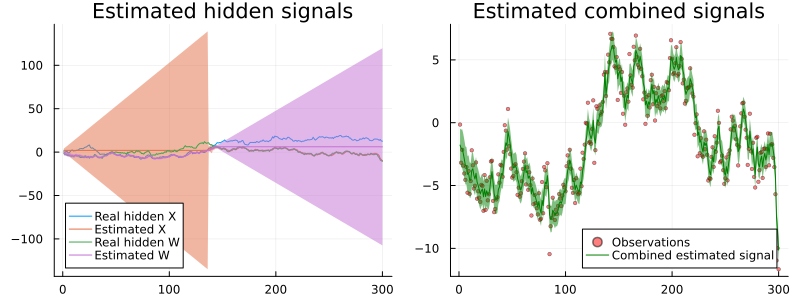

In [120]:
px1 = plot(legend = :bottomleft, title = "Estimated hidden signals")
px2 = plot(legend = :bottomright, title = "Estimated combined signals")

px1 = plot!(px1, rx_real_x, label = "Real hidden X")
px1 = plot!(px1, mean.(rx_xmarginals), ribbon = var.(rx_xmarginals), label = "Estimated X")

px1 = plot!(px1, rx_real_w, label = "Real hidden W")
px1 = plot!(px1, mean.(rx_wmarginals), ribbon = var.(rx_wmarginals), label = "Estimated W")

px2 = scatter!(px2, rx_real_y, label = "Observations", ms = 2, alpha = 0.5, color = :red)
px2 = plot!(px2, mean.(rx_smarginals), ribbon = std.(rx_smarginals), label = "Combined estimated signal", color = :green)

plot(px1, px2, size = (800, 300))

The results are quite similar to the smoothing case and, as we can see, one of the random walk is again in the "disabled" state, does not infer anything and simply increases its variance (which is expected for the random walk).

## Handling Missing Data

An interesting case in filtering and smoothing problems is the processing of missing data. It can happen that sometimes your reading devices failt to acquire the data leading to missing observation.

Let us assume that the following model generates the data

$$\begin{aligned}
    {x}_t &\sim \mathcal{N}\left({x}_{t-1}, 1.0\right) \\
    {y}_t &\sim \mathcal{N}\left({x}_{t}, P \right) 
\end{aligned}$$

with prior ${x}_0 \sim \mathcal{N}({m_{{x}_0}}, {v_{{x}_0}})$. Suppose that our measurement device fails to acquire data from time to time.  In this case, instead of scalar observation $\hat{y}_t \in \mathrm{R}$ we sometimes will catch `missing` observations.

In [121]:
using RxInfer, Plots

In [122]:
@model function smoothing(x0, y)
    
    P ~ Gamma(shape = 0.001, scale = 0.001)
    x_prior ~ Normal(mean = mean(x0), var = var(x0)) 

    local x
    x_prev = x_prior

    for i in 1:length(y)
        x[i] ~ Normal(mean = x_prev, precision = 1.0)
        y[i] ~ Normal(mean = x[i], precision = P)
        
        x_prev = x[i]
    end

end

In [123]:
P = 1.0
n = 250

real_signal     = map(e -> sin(0.05 * e), collect(1:n))
noisy_data      = real_signal + rand(Normal(0.0, sqrt(P)), n);
missing_indices = 100:125
missing_data    = similar(noisy_data, Union{Float64, Missing}, )

copyto!(missing_data, noisy_data)

for index in missing_indices
    missing_data[index] = missing
end

In [124]:
constraints = @constraints begin
    q(x_prior, x, y, P) = q(x_prior, x)q(P)q(y)
end

Constraints: 
    q(x_prior, x, y, P) = q(x_prior, x)q(P)q(y)


In [127]:
x0_prior = NormalMeanVariance(0.0, 1000.0)
initm = @initialization begin
    q(P) = Gamma(0.001, 0.001)
end

result = infer(
    model = smoothing(x0=x0_prior), 
    data  = (y = missing_data,), 
    constraints = constraints,
    initialization = initm, 
    returnvars = (x = KeepLast(),),
    iterations = 20
);

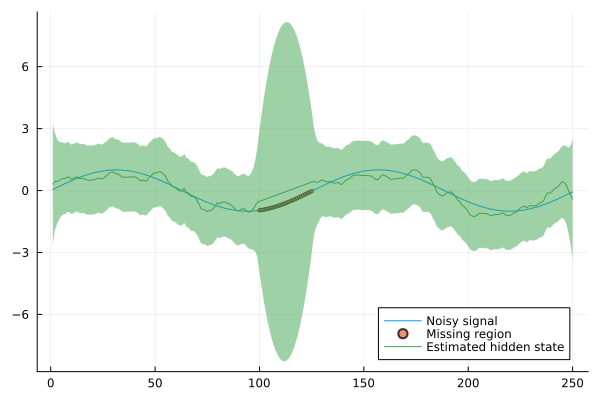

In [128]:
plot(real_signal, label = "Noisy signal", legend = :bottomright)
scatter!(missing_indices, real_signal[missing_indices], ms = 2, opacity = 0.75, label = "Missing region")
plot!(mean.(result.posteriors[:x]), ribbon = var.(result.posteriors[:x]), label = "Estimated hidden state")